In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Xray/"

Mounted at /content/drive
/content/drive/My Drive/Xray


16384/10484 [==============================================] - 0s 0us/step
Found 8631 images belonging to 3 classes.
Found 2875 images belonging to 3 classes.
Image batch shape:  (128, 224, 224, 3)
Label batch shape:  (128, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,567,299
Trainable params: 6,147
Non-trainable params: 23,561,152
_________________________________________________________________
Epoch 1/10
68/68 [==============================] - 3538s 52s/step - loss: 0.6815 - acc: 0.8672
Epoch 2/10
68/68 [==============================] - 120s 2s/step - loss: 0.6420 - acc: 0.9219
Epoch 3/10
68/68 [==============================] - 120s 2s/step - loss: 0.6169 - a

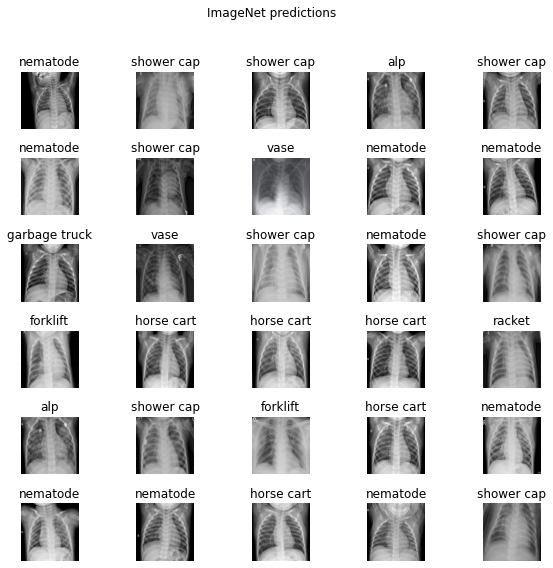

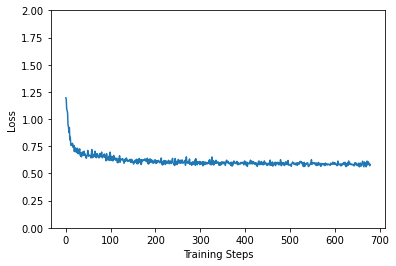

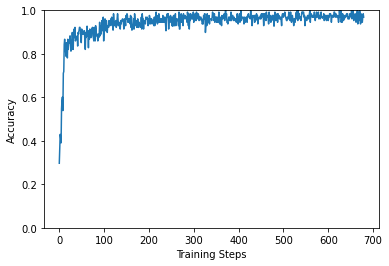

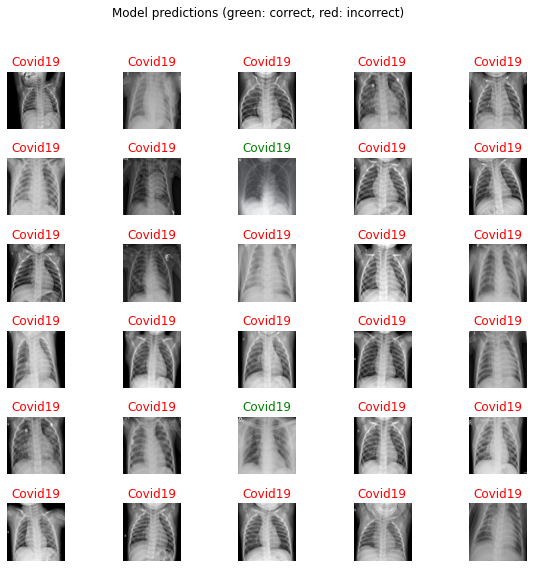

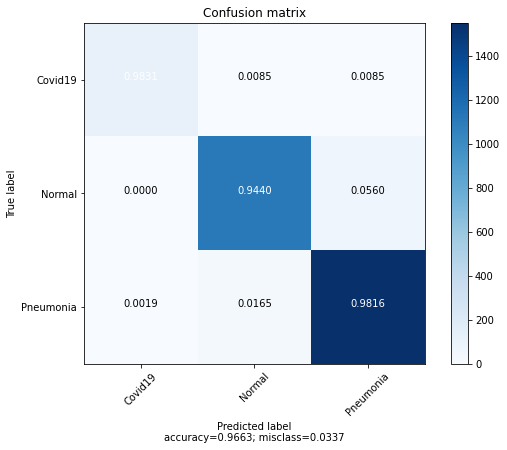

precision: [0.98305085 0.94402036 0.98162231]
recall: [0.97478992 0.97631579 0.9585396 ]
fscore: [0.97890295 0.95989651 0.96994364]
support: [ 119 1140 1616]


In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def fix_dims(tens):
  return np.repeat(tens, 3, -1)

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

IMAGE_SHAPE = (224, 224)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.25)#, preprocessing_function=fix_dims)
image_data = image_generator.flow_from_directory("Xray-Data", target_size=IMAGE_SHAPE, color_mode="rgb", batch_size=128, subset="training", shuffle=True)#grayscale
val_data = image_generator.flow_from_directory("Xray-Data", target_size=IMAGE_SHAPE, color_mode="rgb", batch_size=128, subset="validation", shuffle=False)

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


#
#feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/pnasnet_large/classification/4")
#
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/classification/1", input_shape=IMAGE_SHAPE+(3,))
])

result_batch = classifier.predict(image_batch)
result_batch.shape

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")



feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
               trainable=False, input_shape=(224, 224, 3)) #, arguments=dict(batch_norm_momentum=0.997)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes,activation= 'softmax')
])

model.summary()

predictions = model(image_batch)

predictions.shape

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
    
    
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)


plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

label_id = np.argmax(label_batch, axis=-1)

class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
predicted_batch = model.predict(val_data)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]



plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")



label_id = val_data.classes
print("Predictions:", predicted_id)
print("Ground truth:", label_id)

cm = confusion_matrix(predicted_id, label_id)

plot_confusion_matrix(cm, class_names)

precision, recall, fscore, support = score(label_id, predicted_id)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
 